In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import pandas as pd
import cartopy.crs as ccrs

from scipy.spatial.distance import cdist

In [3]:
turbines = pd.read_csv('windturbines.csv')

In [4]:
turbines.head()

,Unnamed: 0,Wind turbine ID,Terrain height [m],Nacelle height [m],Rotor diameter [m],Max power [MW],Price region,Installation date,Longitude,Latitude
0,0,1781-V-010-001,65.12,30.0,14.0,0.02,SE3,1881-12-31,14.133793,59.253088
1,1,1785-V-006-001,59.07,16.0,11.0,0.01,SE3,1881-12-31,12.802235,59.380151
2,2,1880-V-020-001,45.05,16.0,NaN,0.02,SE3,1881-12-31,15.075022,59.178468
3,3,2321-V-002-001,413.00,NaN,NaN,0.02,SE2,1881-12-31,13.376852,63.437566
4,4,2321-V-001-001,413.58,NaN,NaN,0.10,SE2,1881-12-31,13.376548,63.436982


In [5]:
#Missing values
print(turbines.isnull().sum().sort_values(ascending=False))

Terrain height [m]    79
Rotor diameter [m]    31
Nacelle height [m]    30
Latitude               0
Longitude              0
Installation date      0
Price region           0
Max power [MW]         0
Wind turbine ID        0
Unnamed: 0             0
dtype: int64


In [6]:
#Fill in missing values - replace by median

median_terrain=turbines['Terrain height [m]'].median()
median_nacelle=turbines['Nacelle height [m]'].median()
median_rotor=turbines['Rotor diameter [m]'].median()

values = {'Terrain height [m]': median_terrain, 'Nacelle height [m]': median_nacelle, 'Rotor diameter [m]': median_rotor}
turbines.fillna(value=values, inplace=True)

In [7]:
print(turbines.isnull().sum().sort_values(ascending=False))

Latitude              0
Longitude             0
Installation date     0
Price region          0
Max power [MW]        0
Rotor diameter [m]    0
Nacelle height [m]    0
Terrain height [m]    0
Wind turbine ID       0
Unnamed: 0            0
dtype: int64


In [8]:
turbines.to_csv('windturbines_fillna.csv')

# Replace the missing data with the closest neighbour data

In [9]:
# load the original turbines dataset
turbines = pd.read_csv('windturbines.csv')

#Dealing with one feature with missing value at a time:
features_NA = ['Terrain height [m]', 'Nacelle height [m]', 'Rotor diameter [m]']

for feature in features_NA:
    
    #create a copy of the turbines dataframe without the null values for this feature
    turbines_dropna = turbines.dropna(subset=[feature])

    #create a copy of the turbines dataframe with only the null values
    turbines_null = turbines[turbines[feature].isnull()].reset_index()

    # positions of turbines without missing values
    lonlat_dropna = np.column_stack([turbines_dropna['Longitude'].values, turbines_dropna['Latitude'].values])

    #Find the distance between the turbines with missing value and the nearest non-null neighbour:
    closest_index = []
    for i in range(len(turbines_null)):
        # position of turbine with NaN
        lonlat_null = np.column_stack([turbines_null[turbines_null.index == i]['Longitude'].values, turbines_null[turbines_null.index == i]['Latitude'].values])

        # calculate distances to other turbines
        distance = cdist(lonlat_null, lonlat_dropna)
        closest_index += [np.where(distance == min(distance.flatten()))[1][0]]

    turbines_null.insert(len(turbines_null.columns), "closest_index", closest_index, True)

    #Dictionnary holding the index of the closest turbine 
    keys = turbines_null['Wind turbine ID'].values
    values = turbines_null['closest_index'].values
    swap = dict(zip(keys, values))

    #Replace NaN values with the values of the nearest neighbour
    for i in range(len(turbines)):
        if (turbines[feature].isnull())[i] == True:
            ID = turbines['Wind turbine ID'][i]
            turbines[feature][i] = turbines[feature][swap[ID]]
            
        
turbines.to_csv('windturbines_NaNneighbour.csv') 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
print(turbines.isnull().sum().sort_values(ascending=False))

Latitude              0
Longitude             0
Installation date     0
Price region          0
Max power [MW]        0
Rotor diameter [m]    0
Nacelle height [m]    0
Terrain height [m]    0
Wind turbine ID       0
Unnamed: 0            0
dtype: int64


# Approximate the turbines outside of the weather map to the nearest (lat,lon) inside weather map

In [11]:
#Import data for plotting 

# weather data
weather = netCDF4.Dataset('data_weather/20000915T00Z.nc', 'r')

# turbines and sector power output
turbines = pd.read_csv('windturbines_NaNneighbour.csv')
sector_power = pd.read_csv('windpower_task0_updated.csv')

# time, ensemble member and variable to plot
t = 0
member = 0
variable = 'Temperature'

#Longitude and latitude from the weather netCDF
lons = weather.variables['longitude'][:]
lats = weather.variables['latitude'][:]

#Variable we want to plot
temperature = weather[variable][t, member, :, :]

In [12]:
#Longitude and latitude from the turbines df
tlon = turbines['Longitude'].values
tlat = turbines['Latitude'].values

In [13]:
#Make a dictionnary linking price region name to marker colour
region_colour_dict = {'SE1': 'g', 'SE2': 'm', 'SE3': 'r', 'SE4': 'b'}

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


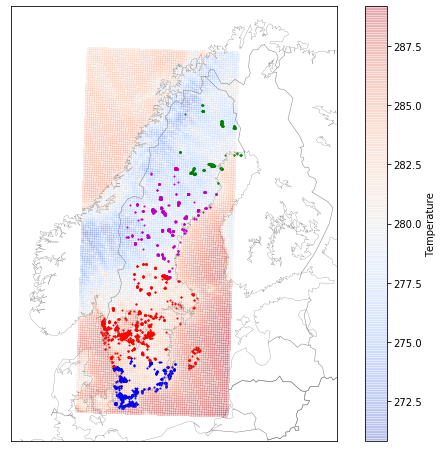

In [181]:
#Original data with turbines outside of the weather map

#Plot a map centred on Sweden
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection ='lcc', resolution = 'l', width=1500000, height=2000000, lat_0=63, lon_0=17)

#Overlay the weather data
m.pcolormesh(lons, lats, temperature, latlon=True, cmap='coolwarm', alpha = 0.2)
plt.colorbar(label=variable)

#Draw coastal lines and country borders
m.drawcoastlines(linewidth = 0.3, color='gray')
m.drawcountries(color='gray')

#Overlay the position of the turbines
x , y = m(tlon, tlat) #Convert lat and long to map projection coordinates
for i in range (0,len(turbines)):
    m.scatter(x[i], y[i], color=region_colour_dict[turbines['Price region'][i]], s = 1)

In [182]:
#View of the easternmost turbines
eastturbines = turbines.loc[(turbines['Longitude'] > 23.354620) & (turbines['Latitude'] < 66.8), ['Wind turbine ID','Longitude','Latitude', 'Price region']]
eastturbines

,Wind turbine ID,Longitude,Latitude,Price region
696,2583-V-001-001,23.713680,65.715537,SE1
697,2583-V-001-002,23.722730,65.715066,SE1
698,2583-V-001-003,23.708286,65.719430,SE1
699,2583-V-001-004,23.718644,65.718889,SE1
700,2583-V-001-005,23.729241,65.718339,SE1
711,2514-V-002-001,23.391791,65.778514,SE1
1170,2514-V-002-002,23.386055,65.781064,SE1
1171,2514-V-002-003,23.380877,65.783052,SE1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


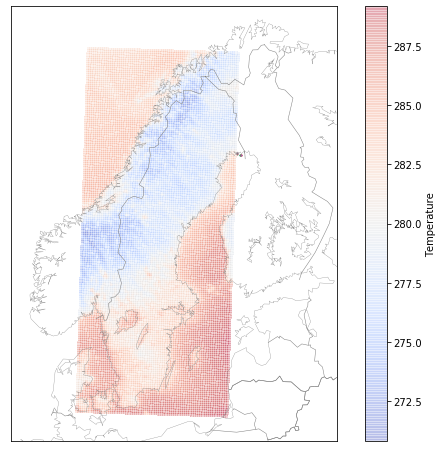

In [183]:
#Plotting the eastern turbines

#Plot a map centred on Sweden
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection ='lcc', resolution = 'l', width=1500000, height=2000000, lat_0=63, lon_0=17)

#Overlay the weather data
m.pcolormesh(lons, lats, temperature, latlon=True, cmap='coolwarm', alpha = 0.2)
plt.colorbar(label=variable)

#Draw coastal lines and country borders
m.drawcoastlines(linewidth = 0.3, color='gray')
m.drawcountries(color='gray')

eastlon = eastturbines['Longitude'].values
eastlat = eastturbines['Latitude'].values

#Overlay the position of the turbines
x , y = m(eastlon, eastlat) #Convert lat and long to map projection coordinates
for i in range (0,len(eastturbines)):
    m.scatter(x[i], y[i], s = 1)

In [184]:
#Shaping the weather lat and lon for easy reading

LatitudeMap = weather.variables['latitude'][:]
LatitudeArray = np.asarray(np.reshape(LatitudeMap, 11999, 'F')) 

LongitudeMap = weather.variables['longitude'][:]
LongitudeArray = np.asarray(np.reshape(LongitudeMap, 11999, 'F')) 

X = np.column_stack((LatitudeArray, LongitudeArray))
weatherlatlon = pd.DataFrame({'Latitude': X[:, 0], 'Longitude': X[:, 1]})

In [186]:
data1 = {'Lat': LatitudeArray,
         'Lon': LongitudeArray}

data2 = {'Lat': eastturbines['Latitude'].values,
         'Lon': eastturbines['Longitude'].values}

In [187]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

In [188]:
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [189]:
df1['point'] = [(x, y) for x,y in zip(df1['Lat'], df1['Lon'])]
df2['point'] = [(x, y) for x,y in zip(df2['Lat'], df2['Lon'])]

df2['closest'] = [closest_point(x, list(df1['point'])) for x in df2['point']]

In [190]:
df2

,Lat,Lon,point,closest
0,65.715537,23.713680,"(65.71553679, 23.71368006)","(65.84287806879848, 23.308561371033825)"
1,65.715066,23.722730,"(65.71506592, 23.72273038)","(65.84287806879848, 23.308561371033825)"
2,65.719430,23.708286,"(65.71942968, 23.70828632)","(65.84287806879848, 23.308561371033825)"
3,65.718889,23.718644,"(65.71888886, 23.71864387)","(65.84287806879848, 23.308561371033825)"
4,65.718339,23.729241,"(65.71833927, 23.72924133)","(65.84287806879848, 23.308561371033825)"
5,65.778514,23.391791,"(65.77851413, 23.39179125)","(65.84287806879848, 23.308561371033825)"
6,65.781064,23.386055,"(65.78106359, 23.38605501)","(65.84287806879848, 23.308561371033825)"
7,65.783052,23.380877,"(65.78305173, 23.38087736)","(65.84287806879848, 23.308561371033825)"


In [191]:
df1.loc[(df1['Lat'] > 65.8) & (df1['Lon'] < 23.31) & (df1['Lon'] > 23.3)]

,Lat,Lon,point
10984,69.997302,23.302560,"(69.99730239894546, 23.302559916927635)"
11468,67.923678,23.305819,"(67.92367839860702, 23.30581857060659)"
11952,65.842878,23.308561,"(65.84287806879848, 23.308561371033825)"


In [192]:
updatelon = df1['Lon'][11952] 
updatelat = df1['Lat'][11952] 

updatelon, updatelat

(23.308561371033825, 65.84287806879848)

In [193]:
#shift the location of the eastturbines to the nearest point of the weather grid
turbines.loc[(turbines['Longitude'] > 23.354620) & (turbines['Latitude'] < 66.8), ('Longitude', 'Latitude')] = (updatelon, updatelat)

In [194]:
turbines.to_csv('windturbines_NaNneighbour_shiftlon.csv') 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


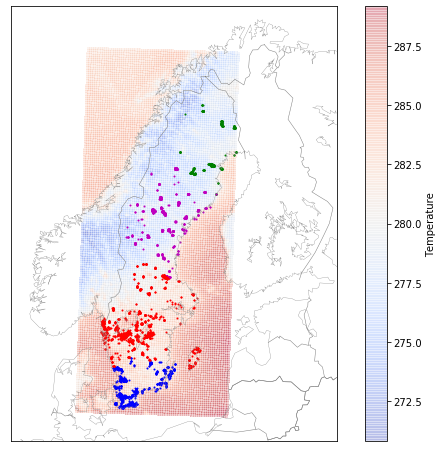

In [195]:
#Plot a map centred on Sweden
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection ='lcc', resolution = 'l', width=1500000, height=2000000, lat_0=63, lon_0=17)

#Overlay the weather data
m.pcolormesh(lons, lats, temperature, latlon=True, cmap='coolwarm', alpha = 0.2)
plt.colorbar(label=variable)

#Draw coastal lines and country borders
m.drawcoastlines(linewidth = 0.3, color='gray')
m.drawcountries(color='gray')

#Overlay the position of the turbines
x , y = m(tlon, tlat) #Convert lat and long to map projection coordinates
for i in range (0,len(turbines)):
    m.scatter(x[i], y[i], color=region_colour_dict[turbines['Price region'][i]], s = 1)